In [1]:
library(brms)
library(tidyverse)
library(BH)
library(loo)
options(mc.cores = 4)
library(magrittr)
options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 200)


Loading required package: Rcpp

Loading 'brms' package (version 2.13.5). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

This is loo ver

In [2]:
#get file names
sfs_files <- list.files("../data/angsd_sfs/", full.names = TRUE)[grep(pattern = "sfs.txt", x =  list.files("../data/angsd_sfs/"))]

#drop empty files
sfs_files <- sfs_files[map_dbl(sfs_files, ~file.size(.x)) > 0]

#parse file names for data details
#ref <- str_extract(sfs_files, "(v5|til11)")
ref <- str_extract(sfs_files, "(v5)")
ssp <- str_extract(sfs_files, "(LR|Teo)")
pop <- str_extract(sfs_files, "--(LR|Teo)--(.+)_fold") %>% str_replace("--(LR|Teo)--(.+)_fold", "\\2")
pop <- paste0(ssp, "_", pop)
fold <- str_extract(sfs_files, "fold\\d") %>% str_remove("fold")
nucs <- str_extract(sfs_files, "fold(0|4)_(..+)_sfs.txt") %>% str_replace("fold(0|4)_(..+)_sfs.txt", "\\2")


#read in data, convert to long, add data details, filter, compute alpha
sfs_df <- 
sfs_files %>% 
    map_df(~{
        df <- read_delim(.x, delim = " ", col_names = FALSE)
        df[, 1:(ncol(df))-1]
    }) %>% 
    mutate(ref, ssp, pop, fold, nucs) %>% 
    mutate(nuc_type = case_when(
              nucs == "AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG" ~ "All",
              nucs == "AT,TA,GC,CG" ~ "SS_WW",
              nucs == "AG,AC,TG,TC" ~ "WS",
              nucs == "GA,GT,CA,CT" ~ "SW")) %>% 
    pivot_longer(cols = starts_with("X"), names_to = "allele_frequency", values_to = "frequency") %>% 
    drop_na() %>% 
    mutate(allele_frequency = as.numeric(str_remove(allele_frequency, "X"))-1) %>% 
    group_by(ref, ssp, pop, fold, nucs) %>% 
    mutate(allele_frequency = allele_frequency/max(allele_frequency)) %>% 
    group_by(fold) %>% 
    group_split() %>% 
    reduce(
        full_join,
        by = c("ref", "ssp", "pop", "nucs", "nuc_type", "allele_frequency"), 
        suffix = c("_0", "_4")
    ) %>% 
    group_by(ref, ssp, pop, nuc_type) %>%
    arrange(ref, ssp, pop, nuc_type, allele_frequency) %>% 
    mutate(fixed_0 = last(frequency_0),
         fixed_4 = last(frequency_4),
         alpha = 1 - (fixed_4/fixed_0) * (frequency_0/frequency_4)
         ) %>% 
    ungroup() %>% 
    drop_na() %>% 
    mutate(alpha_scaled = (alpha - mean(alpha))/ sd(alpha)) 

sfs_df


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_logical()
)



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_logical()
)



── Column specificati


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_double(),
  X13 = col_double(),
  X14 = col_logical()
)



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X1


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X22 = col_logical()
)
ℹ Use `spec()` for the full column specifications.


ref,ssp,pop,fold_0,nucs,nuc_type,allele_frequency,frequency_0,fold_4,frequency_4,fixed_0,fixed_4,alpha,alpha_scaled
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
v5,LR,LR_Amatlan_de_Canas,0,"AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG",All,0.00,1.476178e+07,4,4395397.725,3430.3861,3310.1231,-2.240722e+00,-4.45058167
v5,LR,LR_Amatlan_de_Canas,0,"AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG",All,0.05,3.495491e+04,4,30124.054,3430.3861,3310.1231,-1.196853e-01,-0.39058300
v5,LR,LR_Amatlan_de_Canas,0,"AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG",All,0.10,1.962586e+04,4,19042.987,3430.3861,3310.1231,5.523073e-03,-0.15091452
v5,LR,LR_Amatlan_de_Canas,0,"AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG",All,0.15,1.412335e+04,4,13990.042,3430.3861,3310.1231,2.586334e-02,-0.11198005
v5,LR,LR_Amatlan_de_Canas,0,"AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG",All,0.20,1.015971e+04,4,10392.578,3430.3861,3310.1231,5.667967e-02,-0.05299274
v5,LR,LR_Amatlan_de_Canas,0,"AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG",All,0.25,7.729889e+03,4,8506.308,3430.3861,3310.1231,1.231339e-01,0.07421111
v5,LR,LR_Amatlan_de_Canas,0,"AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG",All,0.30,6.415797e+03,4,6822.549,3430.3861,3310.1231,9.258675e-02,0.01573907
v5,LR,LR_Amatlan_de_Canas,0,"AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG",All,0.35,5.208697e+03,4,5832.507,3430.3861,3310.1231,1.382625e-01,0.10316954
v5,LR,LR_Amatlan_de_Canas,0,"AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG",All,0.40,4.573275e+03,4,5048.026,3430.3861,3310.1231,1.258079e-01,0.07932965


`geom_smooth()` using formula 'y ~ x'



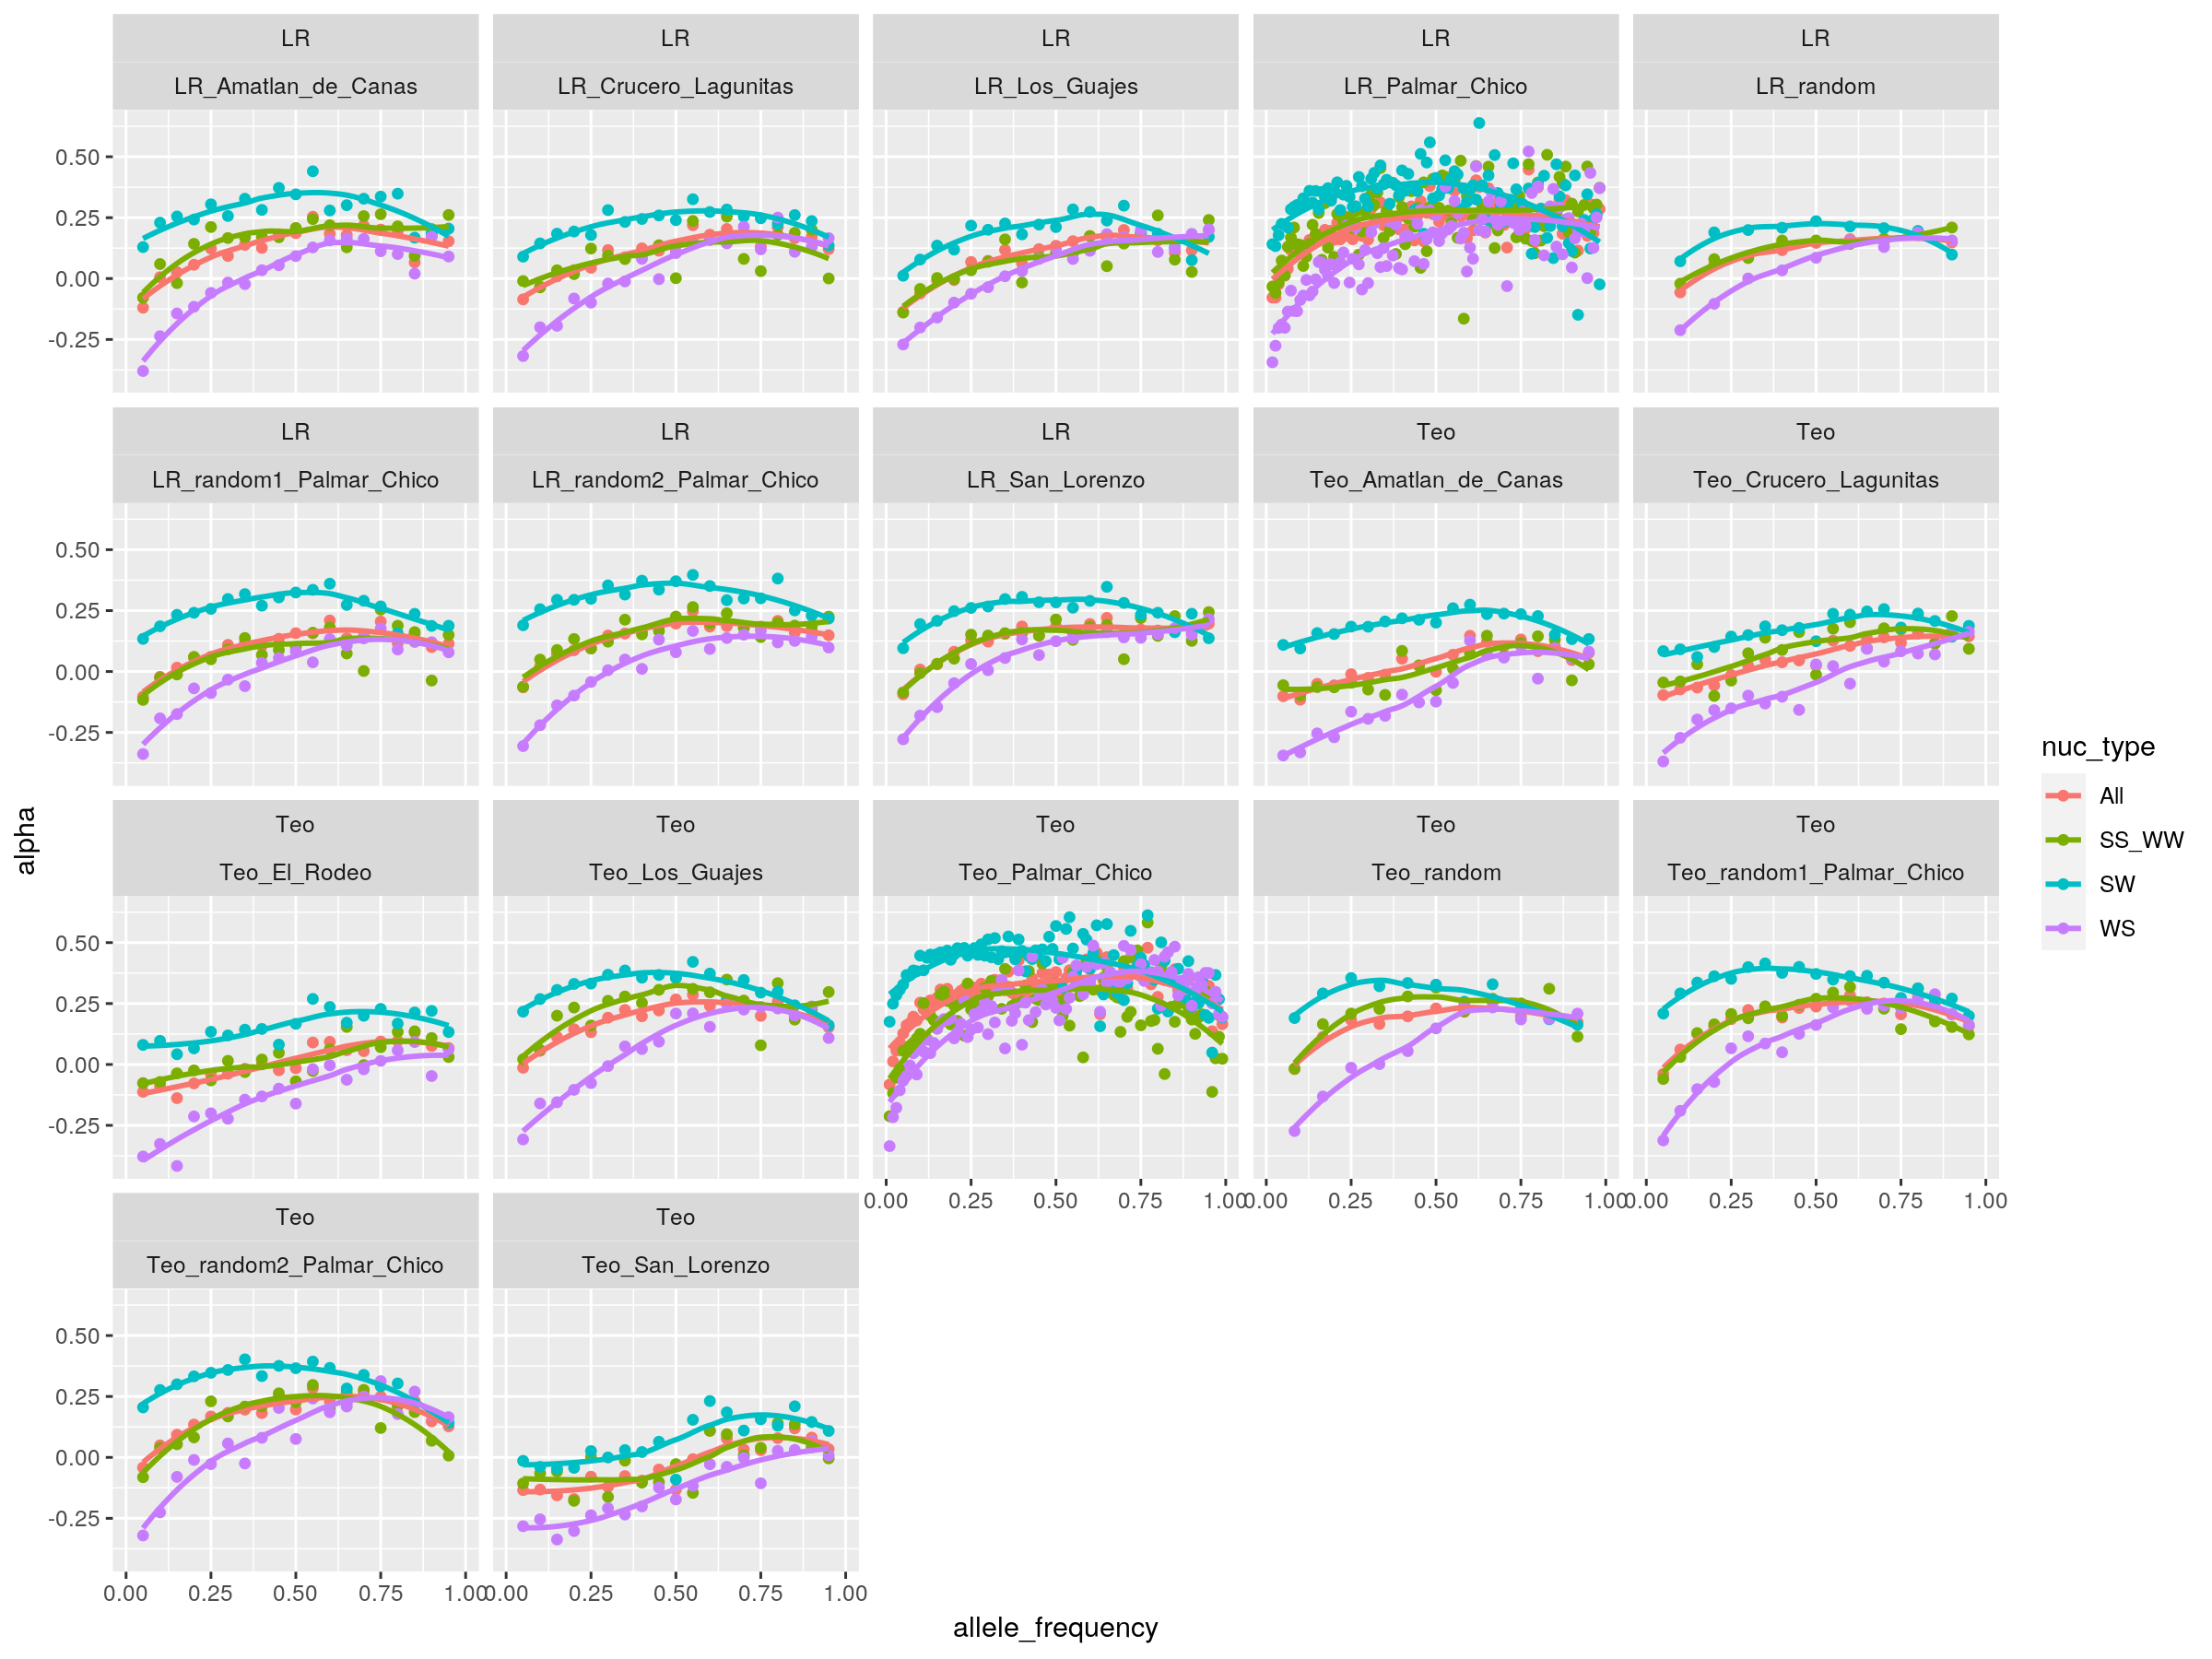

In [3]:
gp <- 0.01
sfs_df %>% 
#filter(ssp == "LR", nuc_type == "SW") %>% 
#filter(grepl("Pal", pop)) %>% 
filter(between(allele_frequency, left = gp, right = 1-gp)) %>% 
ggplot(aes(allele_frequency, alpha, colour = nuc_type)) +
geom_point() +
geom_smooth(method = "loess", se = F) +
facet_wrap(~ ssp + pop)

In [4]:
prior1 <- c(
  set_prior(prior = "normal(0, 0.05)", class = "b",  nlpar = "a"),
    set_prior(prior = "normal(0, .05)", class = "b",  nlpar = "b"),
    set_prior(prior = "normal(0, .05)", class = "b",  nlpar = "c"),
    set_prior(prior = "normal(0, .05)", class = "sd",  nlpar = "a"),
    set_prior(prior = "normal(0, .05)", class = "sd",  nlpar = "b"),
    set_prior(prior = "normal(0, .05)", class = "sd",  nlpar = "c"),
   set_prior(prior = "normal(0, .05)", class = "sigma")
)


get_prior(
bf(
    alpha ~ a + b * exp(-c * allele_frequency), 
          a + b + c ~ 1 + allele_frequency + 
      (1 + allele_frequency | pop) +
      (1 +  allele_frequency | nuc_type) + 
      ssp,
    nl = TRUE
  ),
  #prior = prior1,
  data = filter(sfs_df, 
         between(allele_frequency, 0.1, 0.9)), #!!!
  family = gaussian()
)

print(make_stancode(
bf(
    alpha ~ a + b * exp(-c * allele_frequency), 
          a + b + c ~ 1 + allele_frequency + 
      (1 + allele_frequency | pop) +
      (1 +  allele_frequency | nuc_type) + 
      ssp,

    nl = TRUE
  ),
  prior = prior1,
  data = filter(sfs_df, 
         between(allele_frequency, 0.1, 0.9)), #!!!
  family = gaussian()
))

prior,class,coef,group,resp,dpar,nlpar,bound
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
lkj(1),cor,,,,,,
,cor,,nuc_type,,,,
,cor,,pop,,,,
"student_t(3, 0, 2.5)",sigma,,,,,,
,b,,,,,a,
,b,allele_frequency,,,,a,
,b,Intercept,,,,a,
,b,sspTeo,,,,a,
"student_t(3, 0, 2.5)",sd,,,,,a,


// generated with brms 2.13.5
functions {
}
data {
  int<lower=1> N;  // number of observations
  vector[N] Y;  // response variable
  int<lower=1> K_a;  // number of population-level effects
  matrix[N, K_a] X_a;  // population-level design matrix
  int<lower=1> K_b;  // number of population-level effects
  matrix[N, K_b] X_b;  // population-level design matrix
  int<lower=1> K_c;  // number of population-level effects
  matrix[N, K_c] X_c;  // population-level design matrix
  // covariate vectors for non-linear functions
  vector[N] C_1;
  // data for group-level effects of ID 1
  int<lower=1> N_1;  // number of grouping levels
  int<lower=1> M_1;  // number of coefficients per level
  int<lower=1> J_1[N];  // grouping indicator per observation
  // group-level predictor values
  vector[N] Z_1_a_1;
  vector[N] Z_1_a_2;
  int<lower=1> NC_1;  // number of group-level correlations
  // data for group-level effects of ID 2
  int<lower=1> N_2;  // number of grouping levels
  int<lower=1> 

In [ ]:
#MODELS

prior1 <- c(
    set_prior(prior = "normal(0, 0.1)", class = "b", nlpar = "a"),
    set_prior(prior = "normal(0, 0.1)", class = "b", nlpar = "b", ub = 0),
    set_prior(prior = "normal(0, 0.1)", class = "b", nlpar = "c"),
    set_prior(prior = "normal(0, 0.1)", class = "sd", nlpar = "a"),
    set_prior(prior = "normal(0, 0.1)", class = "sd", nlpar = "b"),
    set_prior(prior = "normal(0, 0.1)", class = "sd", nlpar = "c"),
    set_prior(prior = "normal(0, 0.1)", class = "sigma")
)

delt <- 0.98
treed <- 10
its <- 10000
thn <- 4
chns  <- 4

# 1 + x + (1 + x | g) 
mod_cor <- brm(
  bf(
    alpha ~ a + b * exp(-c * allele_frequency), 
            a + b + c ~ 1 + allele_frequency + 
            (1 + allele_frequency | pop) +
            (1 + allele_frequency | nuc_type) + 
            ssp,
    nl = TRUE),
  data = filter(sfs_df, between(allele_frequency, 0.01, 0.99)), #!!!
  family = gaussian(),
  iter = its,
  thin = thn,
  chains = chns,
  prior = prior1, 
  control = list(adapt_delta = delt, max_treedepth = treed)) %>%
  add_criterion("loo")


mod_cor_no_ssp <- brm(
  bf(
    alpha ~ a + b * exp(-c * allele_frequency), 
            a + b + c ~ 1 + allele_frequency + 
            (1 + allele_frequency | pop) +
            (1 + allele_frequency | nuc_type),
    nl = TRUE),
  data = filter(sfs_df, between(allele_frequency, 0.01, 0.99)), #!!!
  family = gaussian(),
  iter = its,
  thin = thn,
  chains = chns,
  prior = prior1,
  control = list(adapt_delta = delt, max_treedepth = treed)) %>%
  add_criterion("loo")


mod_cor_no_pop <- brm(
  bf(
    alpha ~ a + b * exp(-c * allele_frequency), 
            a + b + c ~ 1 + allele_frequency + 
            (1 + allele_frequency | nuc_type) + 
            ssp,
    nl = TRUE),
  data = filter(sfs_df, between(allele_frequency, 0.01, 0.99)), #!!!
  family = gaussian(),
  iter = its,
  thin = thn,
  chains = chns,
  prior = prior1,
  control = list(adapt_delta = delt, max_treedepth = treed)) %>%
  add_criterion("loo")

mod_cor_no_nuc <- brm(
  bf(
    alpha ~ a + b * exp(-c * allele_frequency), 
            a + b + c ~ 1 + allele_frequency + 
            (1 + allele_frequency | pop) +
            ssp,
    nl = TRUE),
  data = filter(sfs_df, between(allele_frequency, 0.01, 0.99)), #!!!
  family = gaussian(),
  iter = its,
  thin = thn,
  chains = chns,
  prior = prior1,
  control = list(adapt_delta = delt, max_treedepth = treed)) %>%
  add_criterion("loo")

prior2 <- c(
    set_prior(prior = "normal(0, 0.05)", class = "b", nlpar = "a"),
    set_prior(prior = "normal(0, 0.05)", class = "b", nlpar = "b", ub = 0),
    set_prior(prior = "normal(0, 0.05)", class = "b", nlpar = "c"),
    set_prior(prior = "normal(0, 0.05)", class = "sigma")
)

mod_fixed <- brm(
  bf(
    alpha ~ a + b * exp(-c * allele_frequency),
            a + b + c ~ 1 + pop + nuc_type + ssp + pop*nuc_type,
    nl = TRUE),
  data = filter(sfs_df, between(allele_frequency, 0.01, 0.99)), #!!!
  family = gaussian(),
  iter = its,
  thin = thn,
  chains = chns,
  prior = prior2, 
  control = list(adapt_delta = delt, max_treedepth = treed)) %>%
  add_criterion("loo")

#Save models
#commented out to avoid overwriting. 
saveRDS(mod_cor, file = "../data/mk_models/mod_cor.rds")
saveRDS(mod_cor_no_ssp, file = "../data/mk_models/mod_cor_no_ssp.rds")
saveRDS(mod_cor_no_pop, file = "../data/mk_models/mod_cor_no_pop.rds")
saveRDS(mod_cor_no_nuc, file = "../data/mk_models/mod_cor_no_nuc.rds")
saveRDS(mod_fixed, file = "../data/mk_models/mod_fixed.rds")


Compiling Stan program...

Start sampling



In [ ]:
#read models

mod_cor  <- readRDS("../data/mk_models/mod_cor.rds")
mod_cor_no_ssp <- readRDS("../data/mk_models/mod_cor_no_ssp.rds")
mod_cor_no_pop <- readRDS("../data/mk_models/mod_cor_no_pop.rds")
mod_cor_no_nuc <- readRDS("../data/mk_models/mod_cor_no_nuc.rds")
mod_fixed <- readRDS("../data/mk_models/mod_fixed.rds")

#look for warning about pathology
print("1 HERE")
print(mod_cor)
print("2 HERE")
print(mod_cor_no_ssp)
print("3 HERE")
print(mod_cor_no_pop)
print("4 HERE")
print(mod_cor_no_nuc)
print("5 HERE")
print(mod_fixed)


In [ ]:
loo(mod_cor, mod_cor_no_ssp, mod_cor_no_pop, mod_cor_no_nuc, mod_fixed)

In [ ]:
plot(mod_cor)

In [ ]:
#posterior_predict(mod_ssp, nsamples = 10)
pp_check(mod_cor, type = "dens_overlay", 100)

In [ ]:
pred_df <- 
  sfs_df %>% 
  ungroup() %>% 
  select(ssp, nuc_type, pop) %>% 
  unique() %>% 
  mutate(allele_frequency = 1)

full_pred <- fitted(mod_cor, newdata = pred_df, scale = "response") %>% 
  data.frame() %>% 
  set_colnames(c("alpha", "error", "low", "high")) %>% 
  bind_cols(., pred_df)

In [ ]:
dodge <- position_dodge(width=0.2)  
full_plot <- full_pred %>% 
  ggplot(aes(pop, alpha, fill = nuc_type)) +
  geom_segment(aes(x = pop, y = low, xend = pop, yend = high), colour = "black") +
  geom_point(size = 2, pch = 21) +
  facet_wrap(~ssp + nuc_type, scales = "free_x", nrow = 1) +
  #geom_point(aes(pop, alpha_raw), shape = 2) +
  ylab(expression(alpha)) +
  xlab("") +
  #coord_flip()+
  #geom_hline(yintercept = 0, lty =2) +
  theme_classic() +
  scale_fill_discrete(name = "Mutation type") +
  theme(axis.text.x = element_blank()) +
  scale_y_continuous(breaks = scales::pretty_breaks(n = 10))


full_pred %>% 
  mutate(pop = str_replace(pop, "LR_|Teo_", "")) %>%  
  filter(nuc_type == "All") %>% 
  ggplot(aes(pop, alpha)) +
  geom_segment(aes(x = pop, y = low, xend = pop, yend = high), colour = "black") +
  geom_point(size = 4, pch = 21, fill = "dodgerblue") +
  facet_wrap(~ssp, scales = "free_x", nrow = 1) +
  #geom_point(aes(pop, alpha_raw), shape = 2) +
  ylab(expression(alpha)) +
  xlab("") +
  #coord_flip()+
  #geom_hline(yintercept = 0, lty =2) +
  theme_classic(base_size = 18) +
  scale_fill_discrete(name = "Mutation type") +
  theme(axis.text.x=element_text(angle = 80, hjust = 1), legend.position = "n") +
  scale_y_continuous(breaks = scales::pretty_breaks(n = 10))

full_plot

In [ ]:
#LR > Teo?
sfs_df_filt <- filter(sfs_df, between(allele_frequency, 0.01, 0.99))
posts <- posterior_predict(mod_cor)
e_posts <- posterior_epred(mod_cor)
alpha_posts <- posterior_epred(mod_cor, newdata = pred_df,)

In [ ]:
sfs_df_filt %>% 
    mutate(draw = e_posts[sample(1:5000, 1),]) %>% 
    filter(ssp == "Teo") %>% 
    group_by(pop) %>% 
    arrange(allele_frequency) %>% 
    ggplot() +
    geom_point(aes(allele_frequency, alpha, colour = nuc_type)) +
    geom_line(aes(allele_frequency, draw, colour = nuc_type), lwd = 1.2) +
    facet_wrap(~pop)

#plot(sfs_df_filt$allele_frequency, e_posts[sample(1:5000, 1),], col = factor(sfs_df_filt$pop), type = "p")

In [ ]:
#get to post-checks to quantify probability of difference b/w groups and types, 
 #using the first two lines of this little tidbit is key

filter(sfs_df, allele_frequency == 1) %>% 
    mutate(alpha = alpha_posts[sample(1:5000, 1),],
           fixed_sel = alpha * fixed_0) %>% 
    ggplot(aes(alpha, fixed_sel, colour = nuc_type)) + 
    geom_point()
